## S-Power 발전출력량 예측 
- 데이터수집 : S-power 운영관리팀 김성중 계장 
- 데이터량 : 2021.1.13 ~ 2025.8.29간 수집&측정된 총 470건 
- 독립변수 : 대기온도, 습도, 대기압, 열공급량, (복수기)진공도, 열감발량 
- 종속변수 : 기준출력 (필요시 발전출력과 송전출력으로 대체 고려)

--- 
#### 사전 데이터 정비 내역 (raw data --> cleaned data)
1. 날짜 + 시간 -> date_time 컬럼 생성 
2. 컬럼별 표시방식 및 소수점 표시방식 통일 (습도% 표기 혼재 부분 실수로 통일, 해당 컬럼내 데이터의 최대 소수점 자리수 기준 통일)
3. date_time 결측치 8건 : 비정상 데이터로 간주되어 삭제 
4. 습도 결측치 4건 : 해당월의 유사 시간대(+/- 1시간) 습도의 평균으로 대체 
5. 열 공급량 결측치 : 열 공급이 없었던 것으로 간주, 0으로 대체 
6. 복수기_진공도 결측치 14건 : 최 근접일의 수치로 대체 (method = foward fill)
7. 발전출력 결측치 8건 : 송전출력과 발전출력의 차이 평균을 사용, 송전출력 + 13.6으로 대체 
--- 

In [18]:
#data loading 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import xlwings as xw

book = xw.Book('data_modified.xlsx')
sheet = book.sheets[1]
df = sheet.used_range.options(pd.DataFrame, index=False).value  

print(df.shape)
df.head()

(462, 11)


,id,date_time,대기온도,습도,대기압,열공급량,진공도,열감발량,기준출력,발전출력,송전출력
0,1.0,2021-01-13 16:00:00,9.4,0.676,1010.9,337.7,713.0,34.0,746.044597,740.0,729.0
1,2.0,2021-01-13 16:08:00,9.2,0.696,1011.0,338.4,713.0,34.0,746.332816,739.0,730.0
2,3.0,2021-01-19 09:17:00,-8.2,0.387,1030.5,336.5,722.0,34.0,746.919207,809.0,794.0
3,4.0,2021-01-19 09:57:00,-7.4,0.364,1030.9,338.8,720.0,34.0,746.567995,806.0,792.0
4,5.0,2021-01-19 11:08:00,-4.9,0.300,1031.5,340.7,720.0,34.0,748.131104,802.0,788.0


In [19]:
# id drop 
df = df.drop('id', axis=1)
# data_time --> year, month, hour, dayname
df['year'] = df['date_time'].dt.year
df['month'] = df['date_time'].dt.month
df['day'] = df['date_time'].dt.day
df['hour'] = df['date_time'].dt.hour
df['day_week'] = df['date_time'].dt.day_name()
df['주말여부'] = df['day_week'].apply(lambda x: '주말' if x in ['Saturday', 'Sunday'] else '주중')

df.head()

,date_time,대기온도,습도,대기압,열공급량,진공도,열감발량,기준출력,발전출력,송전출력,year,month,day,hour,day_week,주말여부
0,2021-01-13 16:00:00,9.4,0.676,1010.9,337.7,713.0,34.0,746.044597,740.0,729.0,2021,1,13,16,Wednesday,주중
1,2021-01-13 16:08:00,9.2,0.696,1011.0,338.4,713.0,34.0,746.332816,739.0,730.0,2021,1,13,16,Wednesday,주중
2,2021-01-19 09:17:00,-8.2,0.387,1030.5,336.5,722.0,34.0,746.919207,809.0,794.0,2021,1,19,9,Tuesday,주중
3,2021-01-19 09:57:00,-7.4,0.364,1030.9,338.8,720.0,34.0,746.567995,806.0,792.0,2021,1,19,9,Tuesday,주중
4,2021-01-19 11:08:00,-4.9,0.300,1031.5,340.7,720.0,34.0,748.131104,802.0,788.0,2021,1,19,11,Tuesday,주중


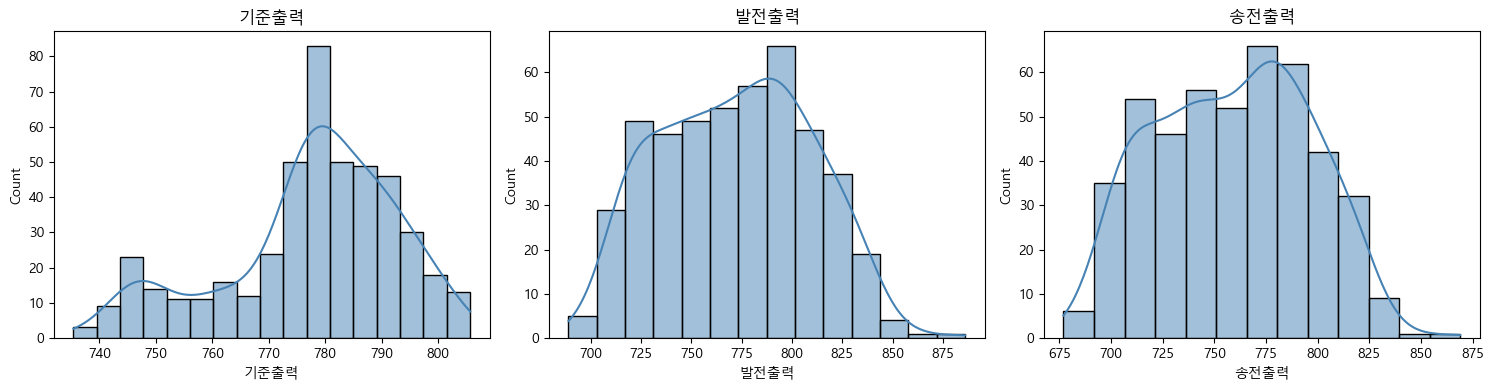

In [20]:
# target 변수후보들의 분포 확인 
import matplotlib.font_manager as fm
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  

fig, axes = plt.subplots(1, 3, figsize=(15, 4))  
sns.histplot(df['기준출력'], kde=True, ax=axes[0], color='steelblue')
sns.histplot(df['발전출력'], kde=True, ax=axes[1], color='steelblue')
sns.histplot(df['송전출력'], kde=True, ax=axes[2], color='steelblue')
axes[0].set_title('기준출력')
axes[1].set_title('발전출력')
axes[2].set_title('송전출력')

plt.tight_layout()
plt.show()

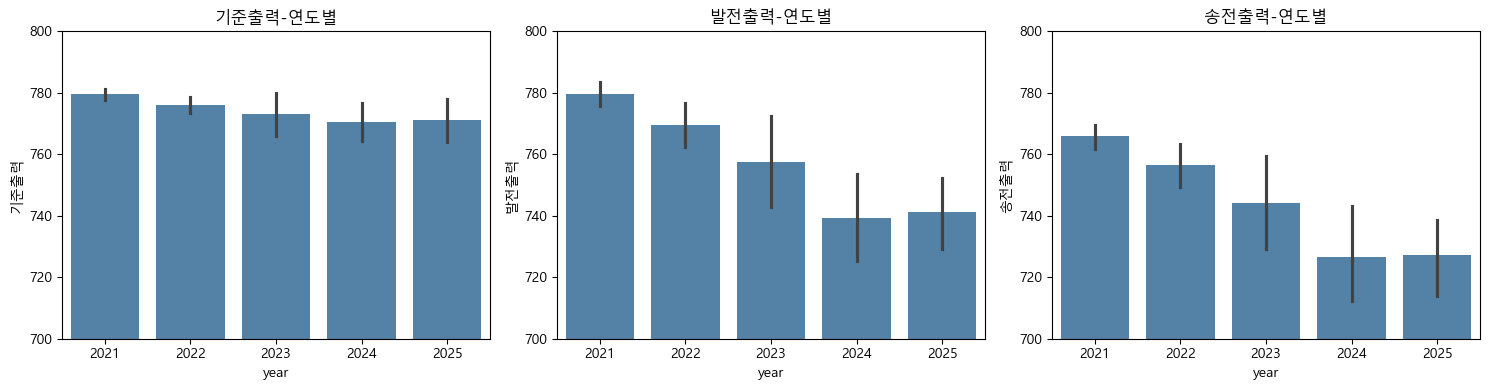

In [21]:
# target 변수들의 연도별 변화 확인 
fig, axes = plt.subplots(1, 3, figsize=(15, 4))  
sns.barplot(data=df, x='year', y='기준출력', ax=axes[0], color='steelblue')
sns.barplot(data=df, x='year', y='발전출력', ax=axes[1], color='steelblue')
sns.barplot(data=df, x='year', y='송전출력', ax=axes[2], color='steelblue')
axes[0].set_title('기준출력-연도별')
axes[1].set_title('발전출력-연도별')
axes[2].set_title('송전출력-연도별')

for ax in axes:
    ax.set_ylim([700, 800])

plt.tight_layout()
plt.show()

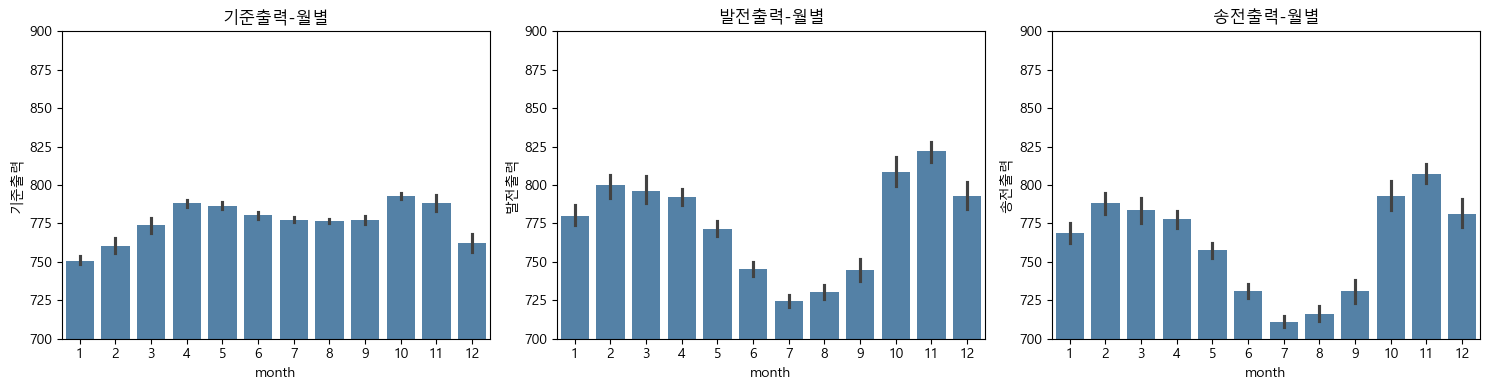

In [22]:
# target 변수들의 월별별 변화 확인 
fig, axes = plt.subplots(1, 3, figsize=(15, 4))  
sns.barplot(data=df, x='month', y='기준출력', ax=axes[0], color='steelblue')
sns.barplot(data=df, x='month', y='발전출력', ax=axes[1], color='steelblue')
sns.barplot(data=df, x='month', y='송전출력', ax=axes[2], color='steelblue')
axes[0].set_title('기준출력-월별')
axes[1].set_title('발전출력-월별')
axes[2].set_title('송전출력-월별')

for ax in axes:
    ax.set_ylim([700, 900])

plt.tight_layout()
plt.show()

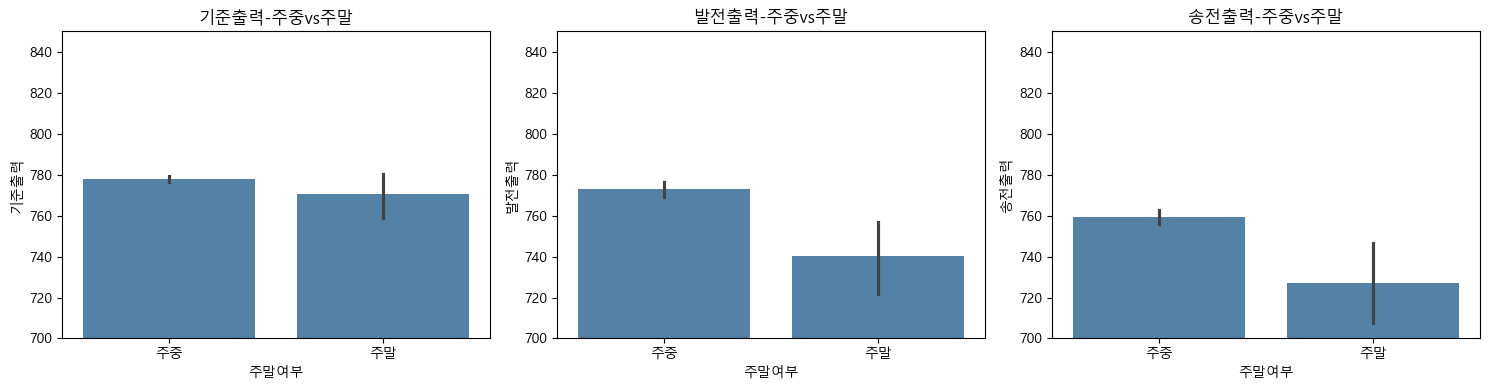

In [23]:
# target 변수들의  주중-주말 비교
fig, axes = plt.subplots(1, 3, figsize=(15, 4))  
sns.barplot(data=df, x='주말여부', y='기준출력', ax=axes[0], color='steelblue')
sns.barplot(data=df, x='주말여부', y='발전출력', ax=axes[1], color='steelblue')
sns.barplot(data=df, x='주말여부', y='송전출력', ax=axes[2], color='steelblue')
axes[0].set_title('기준출력-주중vs주말')
axes[1].set_title('발전출력-주중vs주말')
axes[2].set_title('송전출력-주중vs주말')

for ax in axes:
    ax.set_ylim([700, 850])

plt.tight_layout()
plt.show()

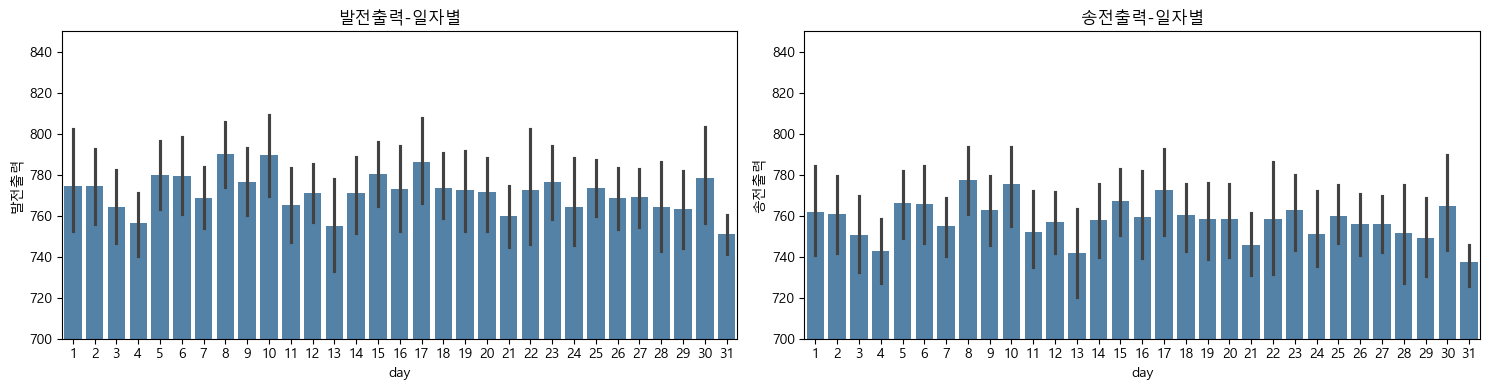

In [24]:
# target 변수들의 일자별 비교
fig, axes = plt.subplots(1, 2, figsize=(15, 4))  
#sns.barplot(data=df, x='day', y='기준출력', ax=axes[0], color='steelblue')
sns.barplot(data=df, x='day', y='발전출력', ax=axes[0], color='steelblue')
sns.barplot(data=df, x='day', y='송전출력', ax=axes[1], color='steelblue')
#axes[0].set_title('기준출력-일자별')
axes[0].set_title('발전출력-일자별')
axes[1].set_title('송전출력-일자별')

for ax in axes:
    ax.set_ylim([700, 850])

plt.tight_layout()
plt.show()

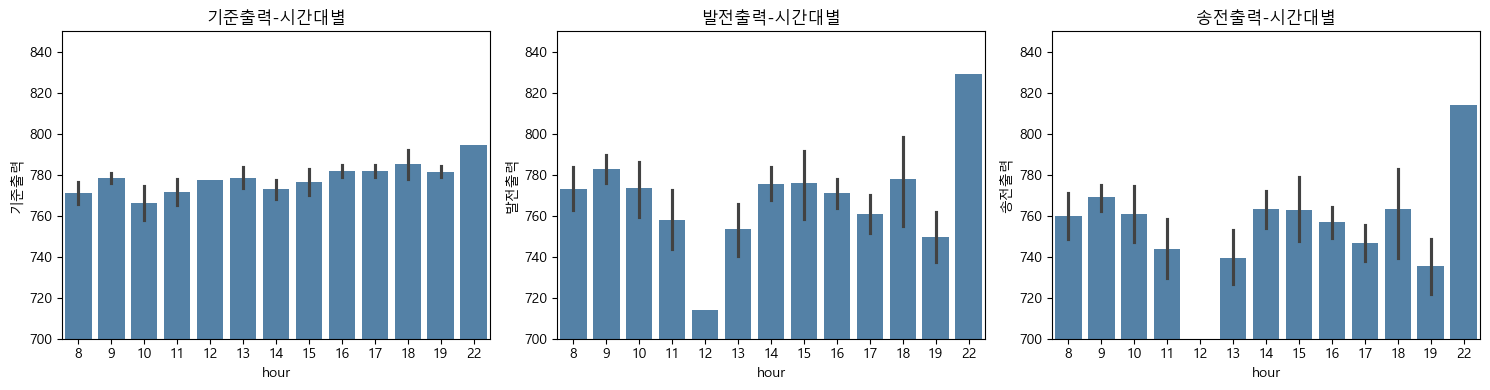

In [25]:
# target 변수들의 시간대별 비교
fig, axes = plt.subplots(1, 3, figsize=(15, 4))  
sns.barplot(data=df, x='hour', y='기준출력', ax=axes[0], color='steelblue')
sns.barplot(data=df, x='hour', y='발전출력', ax=axes[1], color='steelblue')
sns.barplot(data=df, x='hour', y='송전출력', ax=axes[2], color='steelblue')
axes[0].set_title('기준출력-시간대별')
axes[1].set_title('발전출력-시간대별')
axes[2].set_title('송전출력-시간대별')

for ax in axes:
    ax.set_ylim([700, 850])

plt.tight_layout()
plt.show()

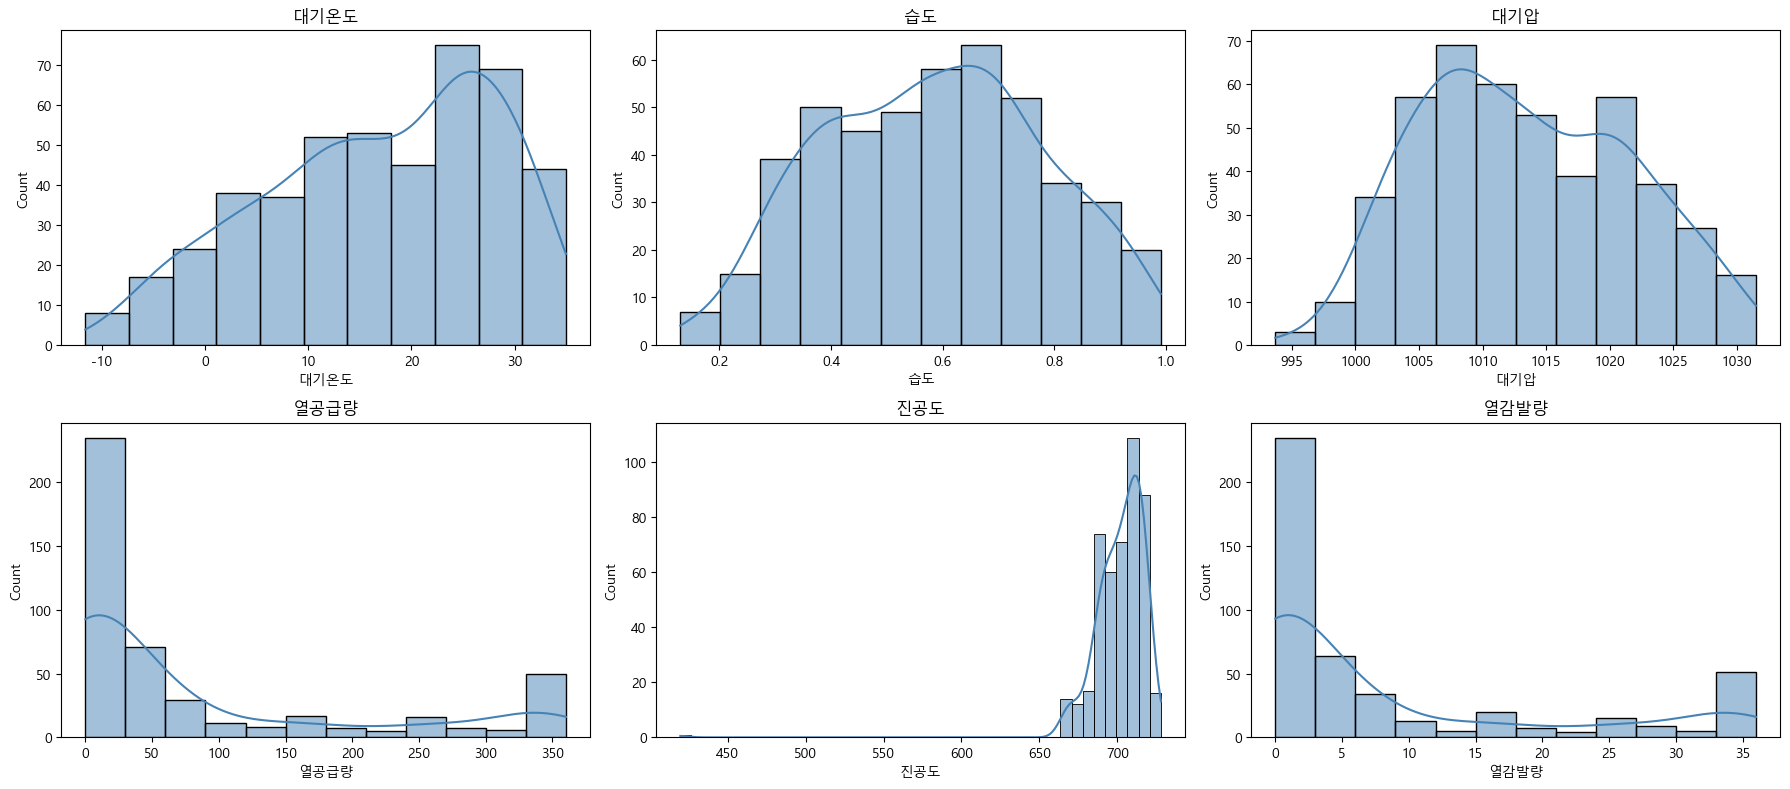

In [26]:
# 독립변수들의 분포 확인 
cols = ['대기온도','습도','대기압','열공급량','진공도','열감발량']

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten() 

for i, col in enumerate(cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color='steelblue')
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

In [27]:
## 특이값 제거 : 진공도 = 419.5인 1건의 데이터 삭제 
df = df[df['진공도'] > 450]

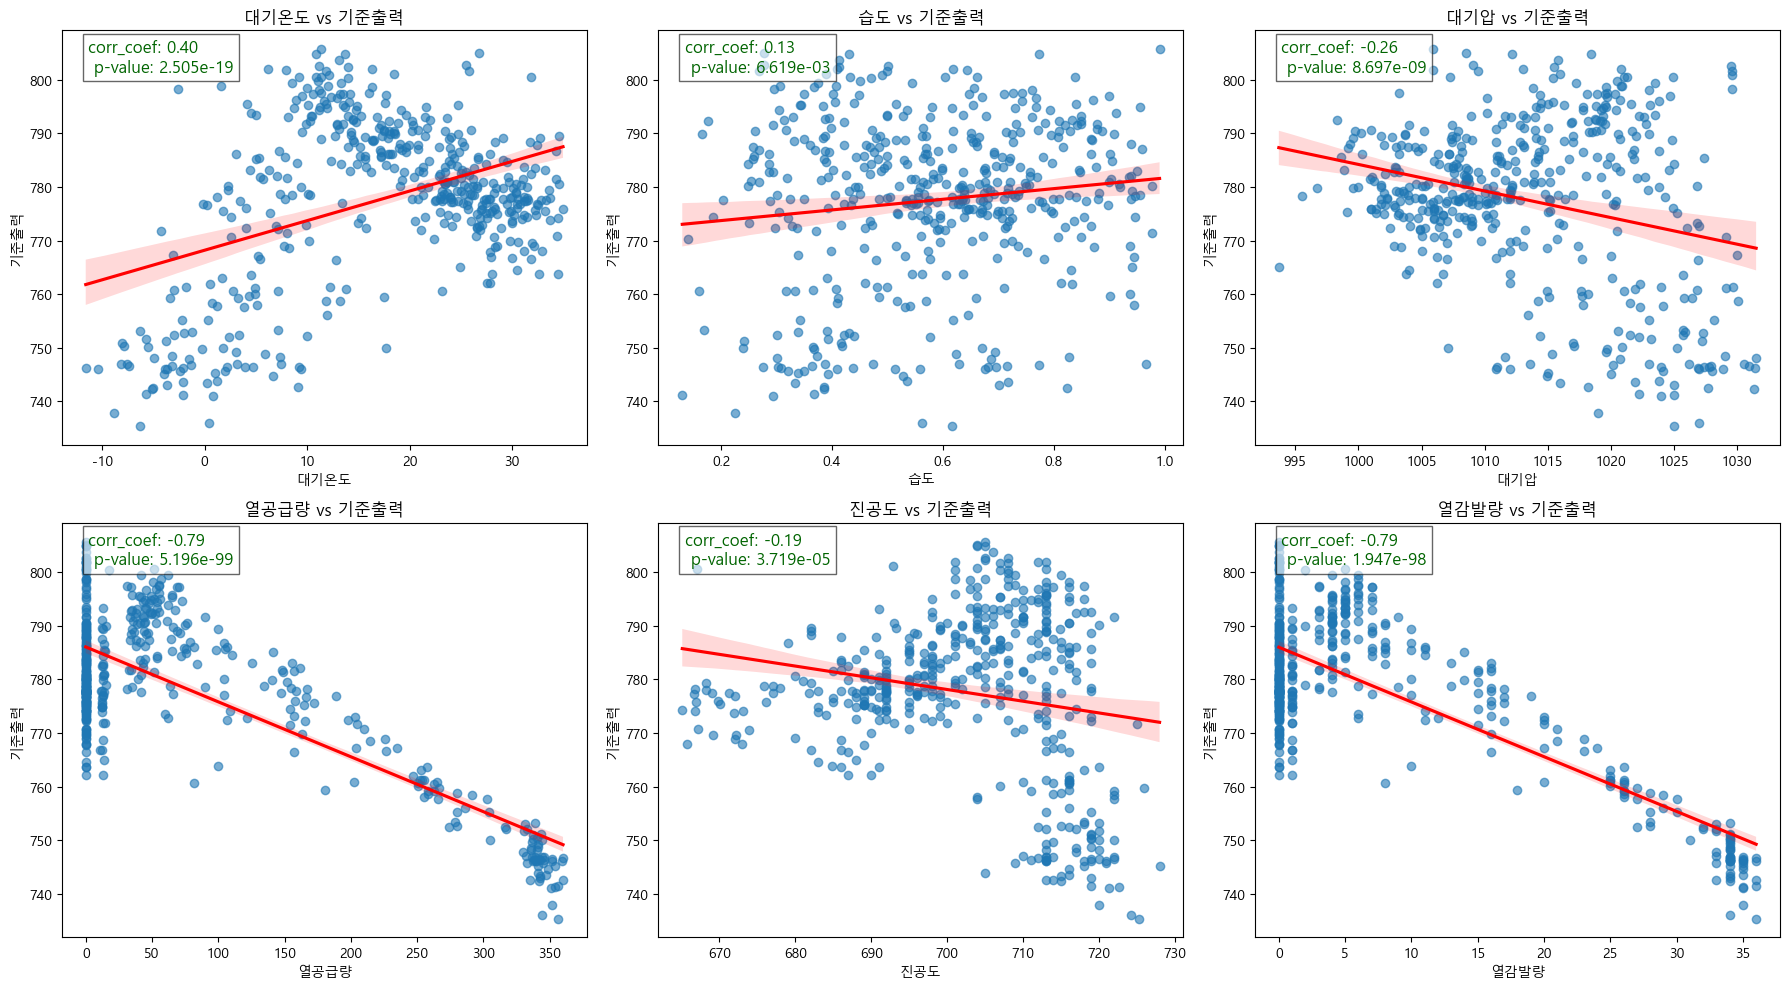

In [28]:
# 독립변수들 ~ 기준출력과의 상관관계 
from scipy.stats import pearsonr
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.regplot(x=df[col], y=df['기준출력'], ax=axes[i],
                scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'})

    corr, p_value = pearsonr(df[col], df['기준출력'])   # 상관계수, p-value 계산
    
    axes[i].set_title(f'{col} vs 기준출력')  
    axes[i].text(0.05, 0.9, 
                 f'corr_coef: {corr:.2f}\n p-value: {p_value:.3e}', # 상관계수, p-value 표시
                 transform=axes[i].transAxes,
                 fontsize=12, color='darkgreen', bbox=dict(facecolor='white', alpha=0.6))   

plt.tight_layout()
plt.show()

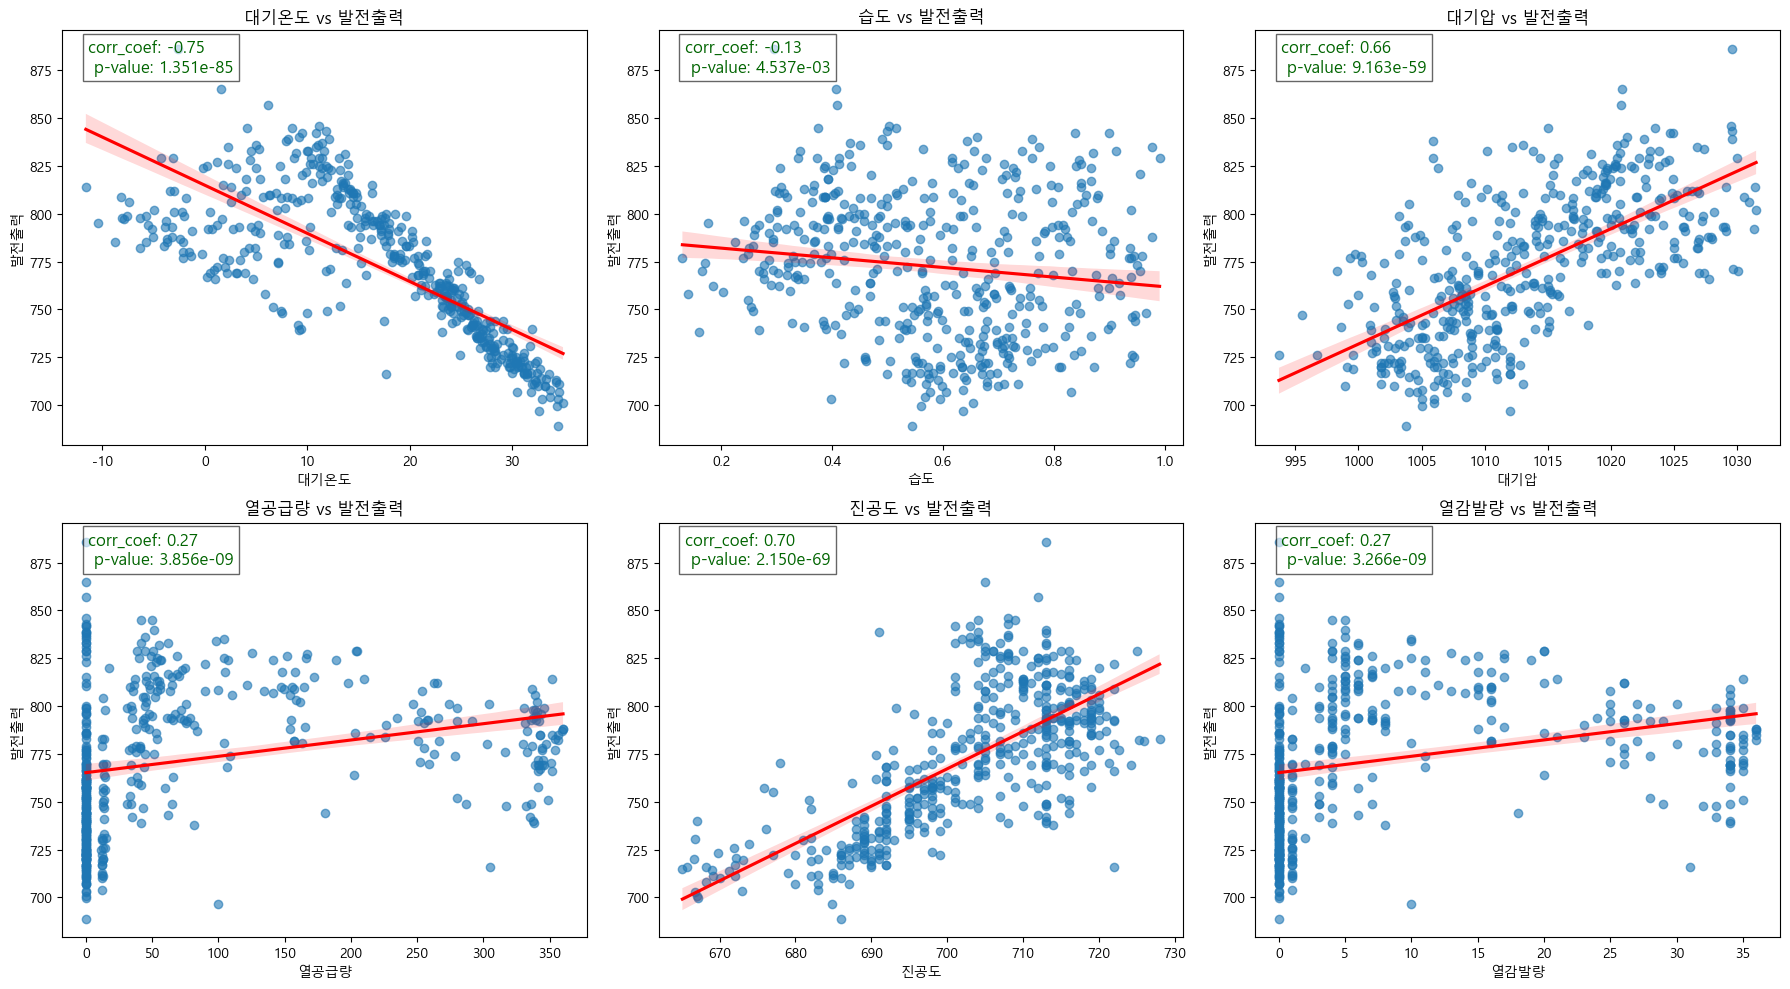

In [29]:
# 독립변수들 ~ 발전출력과의 상관관계 
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.regplot(x=df[col], y=df['발전출력'], ax=axes[i],
                scatter_kws={'alpha': 0.6}, line_kws={'color': 'red'})

    corr, p_value = pearsonr(df[col], df['발전출력'])   # 상관계수, p-value 계산
    
    axes[i].set_title(f'{col} vs 발전출력')  
    axes[i].text(0.05, 0.9, 
                 f'corr_coef: {corr:.2f}\n p-value: {p_value:.3e}', # 상관계수, p-value 표시
                 transform=axes[i].transAxes,
                 fontsize=12, color='darkgreen', bbox=dict(facecolor='white', alpha=0.6))   

plt.tight_layout()
plt.show()

--- 
### EDA Result 
1. 타겟변수 : 
   > - 기준출력은 연도/월별 대체로 일정한데 비해, 발전&송전 출력은 변화가 심한 편. 외부 환경에 따른 전력수요 변화 예측이 목표이므로, 타겟변수를 발전출력으로 지정하는 것이 타당 
   > - 발전&송전 출력은 주중 대비 주말에 뚜렷하게 감소 --> 모델 구성시 고려   
   > - 발전&송전 출력이 22시에 가장 높게 나타남 --> 이유 파악 

2. 독립변수 : 
   > - 대기온도, 대기압, 복수기_진공도는 출력량 예측에 중요한 요인으로 판단됨   
   > - 반면 습도는 거의 영향역이 없어, 모델 구성시 제외 검토   
   > - 열공급걍과 열감발량은 출력에 영향도가 미미하고, 인위적인 이벤트 현상에 가까운 분포임 --> 현업 논의 후 모델 구성시 제외 검토   

In [30]:
# final data 
df.to_csv('df_final.csv', index=False, encoding='utf-8-sig')